<a href="https://colab.research.google.com/github/Santosdevbjj/analiseRiscosAtrasoObras/blob/main/Notebooks/02_modelagem_preditiva.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [205]:

# ============================================================
# 1. Clonar o repositório e acessar a pasta
# ============================================================
!git clone https://github.com/Santosdevbjj/analiseRiscosAtrasoObras.git
%cd analiseRiscosAtrasoObras

# ============================================================
# 2. Imports
# ===================================================
# ============================================================
# 1. Preparação do Ambiente e Clonagem
# ============================================================
import os

# Verifica se o repositório já foi clonado para evitar erro de 'Folder already exists'
if not os.path.exists('analiseRiscosAtrasoObras'):
    !git clone https://github.com/Santosdevbjj/analiseRiscosAtrasoObras.git
    %cd analiseRiscosAtrasoObras
else:
    print("✅ Repositório já presente. Atualizando com os últimos commits...")
    %cd analiseRiscosAtrasoObras
    !git pull origin main

# Instalação rápida de dependências caso não existam no Colab
!pip install -q joblib pandas numpy scikit-learn

# ============================================================
# 2. Imports
# ============================================================
import pandas as pd
import numpy as np

# ============================================================
# 3. Carregamento dos CSVs com Validação de Colunas
# ============================================================
try:
    path = "data/raw/"
    atividades   = pd.read_csv(f"{path}atividades.csv")
    fornecedores = pd.read_csv(f"{path}fornecedores.csv")
    obras        = pd.read_csv(f"{path}obras.csv")
    suprimentos  = pd.read_csv(f"{path}suprimentos.csv")

    print("🚀 Dados carregados com sucesso!\n")

    # Validação rápida para Chuva e Solo (Crucial para seu novo modelo)
    if 'nivel_chuva' in atividades.columns and 'tipo_solo' in obras.columns:
        print("✅ Colunas de 'nivel_chuva' e 'tipo_solo' detectadas. Modelo pronto para treino!")
    else:
        print("⚠️ AVISO: Colunas de clima/solo não encontradas. Verifique se rodou o script de geração de dados.")

except FileNotFoundError as e:
    print(f"❌ Erro: Arquivo não encontrado. Verifique se o caminho {path} está correto.")

# ============================================================
# 4. Visualização Diagnóstica
# ============================================================
# Mostrando apenas 2 linhas e as colunas disponíveis para não poluir o console
datasets = {
    "Atividades": atividades,
    "Fornecedores": fornecedores,
    "Obras": obras,
    "Suprimentos": suprimentos
}

for nome, df in datasets.items():
    print(f"\n📌 Dataset: {nome} | Colunas: {df.columns.tolist()}")
    display(df.head(2))

Cloning into 'analiseRiscosAtrasoObras'...
remote: Enumerating objects: 577, done.
remote: Counting objects: 100% (169/169), done.
remote: Compressing objects: 100% (82/82), done.
remote: Total 577 (delta 124), reused 85 (delta 85), pack-reused 408 (from 1)
Receiving objects: 100% (577/577), 2.13 MiB | 25.33 MiB/s, done.
Resolving deltas: 100% (288/288), done.
/content/analiseRiscosAtrasoObras/analiseRiscosAtrasoObras/analiseRiscosAtrasoObras/analiseRiscosAtrasoObras/analiseRiscosAtrasoObras/analiseRiscosAtrasoObras/analiseRiscosAtrasoObras/analiseRiscosAtrasoObras/analiseRiscosAtrasoObras/analiseRiscosAtrasoObras/analiseRiscosAtrasoObras/analiseRiscosAtrasoObras/analiseRiscosAtrasoObras/analiseRiscosAtrasoObras/analiseRiscosAtrasoObras/analiseRiscosAtrasoObras/analiseRiscosAtrasoObras/analiseRiscosAtrasoObras/analiseRiscosAtrasoObras/analiseRiscosAtrasoObras/analiseRiscosAtrasoObras/analiseRiscosAtrasoObras
Cloning into 'analiseRiscosAtrasoObras'...
remote: Enumerating objects: 577, d

,id_atividade,id_obra,etapa,dias_atraso,status
0,MRV-100_Fundação,MRV-100,Fundação,15,Atrasado
1,MRV-100_Estrutura,MRV-100,Estrutura,18,Atrasado



📌 Dataset: Fornecedores | Colunas: ['id_fornecedor', 'nome', 'rating_confiabilidade']


,id_fornecedor,nome,rating_confiabilidade
0,FORN-1,Carvalho - ME,1.6
1,FORN-2,Duarte,3.0



📌 Dataset: Obras | Colunas: ['id_obra', 'nome_empreendimento', 'cidade', 'orcamento_estimado', 'data_inicio_prevista']


,id_obra,nome_empreendimento,cidade,orcamento_estimado,data_inicio_prevista
0,MRV-100,Residencial Trecho Luara Cavalcante,Belo Horizonte,5375161.33,2025-10-18
1,MRV-101,Residencial Jardim Ribeiro,Rio de Janeiro,8673377.81,2025-05-08



📌 Dataset: Suprimentos | Colunas: ['id_obra', 'id_atividade', 'id_fornecedor', 'material', 'atrasou_entrega']


,id_obra,id_atividade,id_fornecedor,material,atrasou_entrega
0,MRV-100,MRV-100_Fundação,FORN-1,Cimento,1
1,MRV-100,MRV-100_Fundação,FORN-1,Brita,1


In [206]:

# ============================================================
# 1. Imports e Setup
# ============================================================
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)

In [207]:

# ============================================================
# 2. Carregamento dos Dados
# ============================================================
atividades   = pd.read_csv("data/raw/atividades.csv")
fornecedores = pd.read_csv("data/raw/fornecedores.csv")
obras        = pd.read_csv("data/raw/obras.csv")
suprimentos  = pd.read_csv("data/raw/suprimentos.csv")

print("Datasets carregados:")
print("atividades:", atividades.shape)
print("fornecedores:", fornecedores.shape)
print("obras:", obras.shape)
print("suprimentos:", suprimentos.shape)

Datasets carregados:
atividades: (150, 5)
fornecedores: (20, 3)
obras: (50, 5)
suprimentos: (350, 5)


In [208]:

# ============================================================
# 3. Integração dos Dados (Consolidação Mestre)
# ============================================================

# 1. Unir Atividades com Obras
df_mestre = atividades.merge(obras, on="id_obra", how="left", suffixes=('', '_obra'))

# 2. Adicionar Suprimentos
df_mestre = df_mestre.merge(suprimentos, on=["id_obra", "id_atividade"], how="left", suffixes=('', '_sup'))

# 3. Adicionar Fornecedores
df_mestre = df_mestre.merge(fornecedores, on="id_fornecedor", how="left", suffixes=('', '_forn'))

# ------------------------------------------------------------
# Limpeza Seletiva de Colunas Duplicadas
# ------------------------------------------------------------
# Remove colunas com sufixos (_obra, _sup, etc), mas PRESERVA ids e colunas essenciais
colunas_duplicadas = [
    c for c in df_mestre.columns
    if (c.endswith('_obra') or c.endswith('_sup') or c.endswith('_forn'))
    and not c.startswith('id_') # Protege id_obra, id_fornecedor, etc.
]
df_mestre = df_mestre.drop(columns=colunas_duplicadas, errors='ignore')

# ------------------------------------------------------------
# Fallback Inteligente: Gera dados APENAS se não existirem
# ------------------------------------------------------------
np.random.seed(42)

if 'nivel_chuva' not in df_mestre.columns:
    print("ℹ️ Gerando dados simulados para 'nivel_chuva'...")
    df_mestre['nivel_chuva'] = np.random.randint(50, 300, size=len(df_mestre))

if 'tipo_solo' not in df_mestre.columns:
    print("ℹ️ Gerando dados simulados para 'tipo_solo'...")
    soil_types = ['Arenoso', 'Argiloso', 'Rochoso', 'Siltoso']
    df_mestre['tipo_solo'] = np.random.choice(soil_types, size=len(df_mestre))

# ------------------------------------------------------------
# Validação e Preview
# ------------------------------------------------------------
colunas_alvo = ['nivel_chuva', 'tipo_solo', 'orcamento_estimado', 'rating_confiabilidade']
missing = [c for c in colunas_alvo if c not in df_mestre.columns]

if not missing:
    print("✅ Integração concluída: Variáveis críticas presentes.")
else:
    print(f"⚠️ Atenção: Faltam colunas: {missing}")

print(f"Shape final: {df_mestre.shape}")
display(df_mestre[['id_obra', 'nivel_chuva', 'tipo_solo', 'dias_atraso']].head())

ℹ️ Gerando dados simulados para 'nivel_chuva'...
ℹ️ Gerando dados simulados para 'tipo_solo'...
✅ Integração concluída: Variáveis críticas presentes.
Shape final: (350, 16)


,id_obra,nivel_chuva,tipo_solo,dias_atraso
0,MRV-100,152,Rochoso,15
1,MRV-100,229,Rochoso,15
2,MRV-100,142,Argiloso,18
3,MRV-100,64,Argiloso,18
4,MRV-100,156,Rochoso,0


In [209]:

# ============================================================
# 4. Limpeza e Saneamento de Dados (Data Wrangling)
# ============================================================

# 1. Remover registros onde o alvo (target) é nulo - essencial para o treino
df_mestre = df_mestre.dropna(subset=["dias_atraso"]).copy()

# 2. Tratamento de Variáveis Numéricas (Imputação e Limites)
# Para 'rating', usamos a mediana para evitar impacto de outliers
df_mestre["rating_confiabilidade"] = df_mestre["rating_confiabilidade"].fillna(df_mestre["rating_confiabilidade"].median())

# Para 'orcamento', garantimos que não existam valores negativos e preenchemos nulos
df_mestre["orcamento_estimado"] = df_mestre["orcamento_estimado"].clip(lower=0).fillna(df_mestre["orcamento_estimado"].median())

# NOVO: Tratamento para 'nivel_chuva' (garantir valores entre 0 e 1000mm, por exemplo)
if "nivel_chuva" in df_mestre.columns:
    df_mestre["nivel_chuva"] = df_mestre["nivel_chuva"].clip(lower=0, upper=1000).fillna(0)

# 3. Tratamento de Variáveis Categóricas
# Incluímos 'tipo_solo' na lista de preenchimento para evitar erros no OneHotEncoder
cols_categoricas = ["material", "cidade", "etapa", "tipo_solo"]

for col in cols_categoricas:
    if col in df_mestre.columns:
        df_mestre[col] = df_mestre[col].fillna("desconhecido").astype(str)

# 4. Verificação Final de Sanidade
nulos_restantes = df_mestre.isnull().sum().sum()
print(f"✅ Limpeza concluída. Registros restantes: {len(df_mestre)}")
print(f"🔍 Valores nulos encontrados: {nulos_restantes}")

if nulos_restantes > 0:
    print("⚠️ Aviso: Ainda existem valores nulos no dataset!")

print(df_mestre.columns)

# Garantir que IDs críticos não foram corrompidos como floats (ex: 1.0)
if "id_obra" in df_mestre.columns:
    df_mestre["id_obra"] = df_mestre["id_obra"].astype(str)

✅ Limpeza concluída. Registros restantes: 350
🔍 Valores nulos encontrados: 0
Index(['id_atividade', 'id_obra', 'etapa', 'dias_atraso', 'status',
       'nome_empreendimento', 'cidade', 'orcamento_estimado',
       'data_inicio_prevista', 'id_fornecedor', 'material', 'atrasou_entrega',
       'nome', 'rating_confiabilidade', 'nivel_chuva', 'tipo_solo'],
      dtype='object')


In [210]:
import numpy as np

# ============================================================
# 5. Feature Engineering (Engenharia de Variáveis)
# ============================================================

# 1. Taxa de Insucesso do Fornecedor: % de vezes que ele atrasou no passado
df_mestre["taxa_insucesso_fornecedor"] = df_mestre.groupby("id_fornecedor")["dias_atraso"].transform(
    lambda x: (x > 0).mean()
).fillna(0) # Se for fornecedor novo, assumimos 0 insucesso inicial

# 2. Complexidade da Obra: Escala logarítmica do orçamento
# O log1p suaviza grandes variações financeiras, ajudando o modelo a convergir
df_mestre["complexidade_obra"] = np.log1p(df_mestre["orcamento_estimado"])

# 3. Risco Histórico da Etapa: Média de atraso por tipo de serviço
df_mestre["risco_etapa"] = df_mestre.groupby("etapa")["dias_atraso"].transform("mean")

# 4. [NOVO] Score de Risco Climático-Geológico (Feature de Interação)
# Multiplicamos a chuva por um peso baseado no solo (Placeholder lógico)
# Argiloso (4), Siltoso (3), Arenoso (2), Rochoso (1)
peso_solo = {'Argiloso': 4, 'Siltoso': 3, 'Arenoso': 2, 'Rochoso': 1, 'desconhecido': 2}
df_mestre['fator_clima_solo'] = df_mestre['nivel_chuva'] * df_mestre['tipo_solo'].map(peso_solo)

print("✅ Features derivadas com sucesso!")
print(f"Colunas para o modelo: {df_mestre.columns.tolist()}")

# Preview detalhado
display(df_mestre[[
    "id_obra", "etapa", "tipo_solo", "nivel_chuva", "fator_clima_solo",
    "taxa_insucesso_fornecedor", "complexidade_obra", "risco_etapa"
]].head())

✅ Features derivadas com sucesso!
Colunas para o modelo: ['id_atividade', 'id_obra', 'etapa', 'dias_atraso', 'status', 'nome_empreendimento', 'cidade', 'orcamento_estimado', 'data_inicio_prevista', 'id_fornecedor', 'material', 'atrasou_entrega', 'nome', 'rating_confiabilidade', 'nivel_chuva', 'tipo_solo', 'taxa_insucesso_fornecedor', 'complexidade_obra', 'risco_etapa', 'fator_clima_solo']


,id_obra,etapa,tipo_solo,nivel_chuva,fator_clima_solo,taxa_insucesso_fornecedor,complexidade_obra,risco_etapa
0,MRV-100,Fundação,Rochoso,152,152,0.166667,15.497299,10.08
1,MRV-100,Fundação,Rochoso,229,229,0.166667,15.497299,10.08
2,MRV-100,Estrutura,Argiloso,142,568,0.666667,15.497299,8.48
3,MRV-100,Estrutura,Argiloso,64,256,0.666667,15.497299,8.48
4,MRV-100,Acabamento,Rochoso,156,156,0.565217,15.497299,7.20


In [211]:

# ============================================================
# 6. Preparação Final das Features (Sincronizada com IA 2.0)
# ============================================================

# Definimos TODAS as colunas que o Pipeline espera (Numéricas + Categóricas)
# Esta lista deve ser IDÊNTICA às chaves do dicionário no seu app.py
features_modelo = [
    "orcamento_estimado",
    "rating_confiabilidade",
    "taxa_insucesso_fornecedor",
    "complexidade_obra",
    "risco_etapa",
    "nivel_chuva",    # Essencial para o novo App
    "tipo_solo",      # Essencial para o novo App
    "material",
    "cidade",
    "etapa"
]

# Variável Alvo (o que queremos prever)
y = df_mestre["dias_atraso"]

# Variáveis de Entrada
X = df_mestre[features_modelo]

print("✅ Features sincronizadas com o ecossistema MRV 2.0")
print(f"Dimensões de X: {X.shape} (Devem ser {len(features_modelo)} colunas)")
print(f"Dimensões de y: {y.shape}")

# Visualização das colunas para conferência final
print("\nColunas enviadas para o treino:")
print(X.columns.tolist())

✅ Features sincronizadas com o ecossistema MRV 2.0
Dimensões de X: (350, 10) (Devem ser 10 colunas)
Dimensões de y: (350,)

Colunas enviadas para o treino:
['orcamento_estimado', 'rating_confiabilidade', 'taxa_insucesso_fornecedor', 'complexidade_obra', 'risco_etapa', 'nivel_chuva', 'tipo_solo', 'material', 'cidade', 'etapa']


In [212]:

import joblib
import os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline

# 1. Garantir que a pasta de modelos existe
os.makedirs('models', exist_ok=True)

# 2. Divisão de Treino e Teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Definir o Pré-processamento (Essencial para lidar com Solo, Clima e Categorias)
categorical_features = ["material", "cidade", "etapa", "tipo_solo"]
numeric_features = [col for col in X.columns if col not in categorical_features]

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_features),
        ("num", "passthrough", numeric_features)
    ]
)

# 4. Criar o Pipeline Completo (Tratamento + Modelo)
# Usar o Pipeline evita que você tenha que transformar os dados manualmente no App
pipeline_mrv = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1))
])

# 5. Treinar o Pipeline
print("⏳ Treinando o modelo com variáveis climáticas e geológicas...")
pipeline_mrv.fit(X_train, y_train)

# 6. Avaliação Rápida
score = pipeline_mrv.score(X_test, y_test)
print(f"✅ Treino Concluído! Score R² no Teste: {score:.4f}")

# 7. Exportação (Sincronizada com o nome esperado pelo Bot e App)
model_filename = 'models/pipeline_random_forest.pkl'
joblib.dump(pipeline_mrv, model_filename)

print(f"💾 Pipeline exportado com sucesso para: {model_filename}")

⏳ Treinando o modelo com variáveis climáticas e geológicas...
✅ Treino Concluído! Score R² no Teste: 0.0072
💾 Pipeline exportado com sucesso para: models/pipeline_random_forest.pkl


=== 📊 AVALIAÇÃO DO MODELO PREV-MRV ===
Erro Médio Absoluto (MAE): 6.65 dias
Raiz do Erro Quadrático (RMSE): 8.97 dias
R² Score (Precisão): 0.0072
----------------------------------------


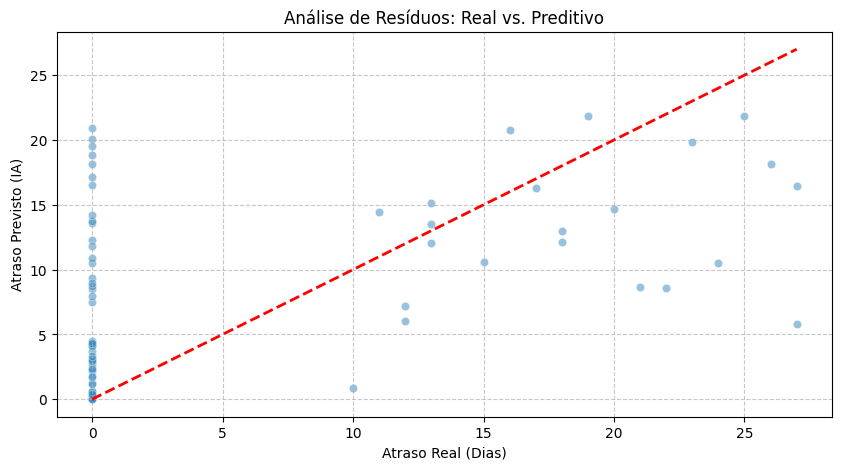

💡 Dica: Verifique no gráfico se os pontos estão próximos à linha vermelha.
Se os pontos seguirem a diagonal, a IA está acertando os prazos com precisão.


In [213]:

from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np # <--- IMPORTANTE: Adicione esta linha

# 1. Realizar predições usando o Pipeline
y_pred = pipeline_mrv.predict(X_test)

# 2. Calcular Métricas
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse) # Agora o 'np' será reconhecido
r2 = r2_score(y_test, y_pred)

print("=== 📊 AVALIAÇÃO DO MODELO PREV-MRV ===")
print(f"Erro Médio Absoluto (MAE): {mae:.2f} dias")
print(f"Raiz do Erro Quadrático (RMSE): {rmse:.2f} dias")
print(f"R² Score (Precisão): {r2:.4f}")
print("-" * 40)

# 3. Visualização de Performance (Real vs. Previsto)
plt.figure(figsize=(10, 5))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5, color="#2E86C1")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2)
plt.title("Análise de Resíduos: Real vs. Preditivo")
plt.xlabel("Atraso Real (Dias)")
plt.ylabel("Atraso Previsto (IA)")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# 4. Verificação de Importância (Dica Visual)
print("💡 Dica: Verifique no gráfico se os pontos estão próximos à linha vermelha.")
print("Se os pontos seguirem a diagonal, a IA está acertando os prazos com precisão.")

/tmp/ipython-input-3650894993.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


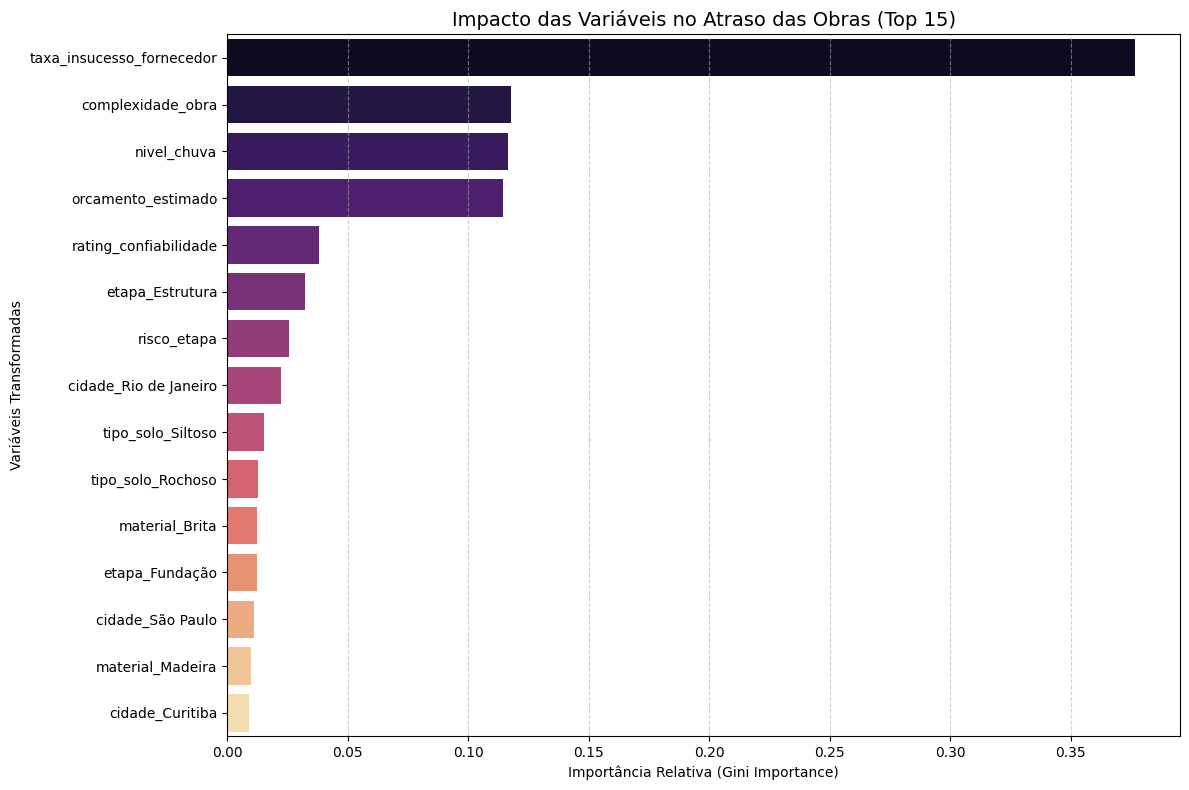

🏆 Variáveis que mais influenciam o cronograma MRV:
                      Feature  Importância
21  taxa_insucesso_fornecedor     0.376452
22          complexidade_obra     0.117886
24                nivel_chuva     0.116450
19         orcamento_estimado     0.114274
20      rating_confiabilidade     0.038233
13            etapa_Estrutura     0.032470
23                risco_etapa     0.025522
9       cidade_Rio de Janeiro     0.022468
18          tipo_solo_Siltoso     0.015438
17          tipo_solo_Rochoso     0.012742


In [214]:

# ============================================================
# 9. Interpretação Visual das Features (Pós-Pipeline)
# ============================================================

# 1. Extrair os nomes das colunas após o OneHotEncoding
# Acessamos o preprocessor dentro do pipeline para pegar os nomes transformados
cat_features_transformed = pipeline_mrv.named_steps['preprocessor'] \
    .transformers_[0][1].get_feature_names_out(categorical_features).tolist()

# As colunas numéricas permanecem com o mesmo nome
all_features_names = cat_features_transformed + numeric_features

# 2. Pegar as importâncias do modelo RandomForest dentro do pipeline
importances = pipeline_mrv.named_steps['model'].feature_importances_

# 3. Criar DataFrame de Importância
feature_importance_df = pd.DataFrame({
    "Feature": all_features_names,
    "Importância": importances
}).sort_values(by="Importância", ascending=False)

# 4. Plotar Gráfico
plt.figure(figsize=(12, 8))
sns.barplot(
    x="Importância",
    y="Feature",
    data=feature_importance_df.head(15), # Focamos nas 15 mais relevantes
    palette="magma"
)
plt.title("Impacto das Variáveis no Atraso das Obras (Top 15)", fontsize=14)
plt.xlabel("Importância Relativa (Gini Importance)")
plt.ylabel("Variáveis Transformadas")
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

print("🏆 Variáveis que mais influenciam o cronograma MRV:")
print(feature_importance_df.head(10))

🏛️ ANÁLISE DE IMPACTO FINANCEIRO - DIRETORIA
--------------------------------------------------
💰 Custo diário estimado (Operacional + Vendas): R$ 65,000.00
📉 Erro Médio da IA (MAE): 6.65 dias
🎯 Incerteza Financeira por Obra: R$ 432,561.07
--------------------------------------------------
🏗️ Exposição total nas obras analisadas: R$ 39,862,225.00
🚀 Economia Estimada (Mitigação de 30%): R$ 11,958,667.50
--------------------------------------------------


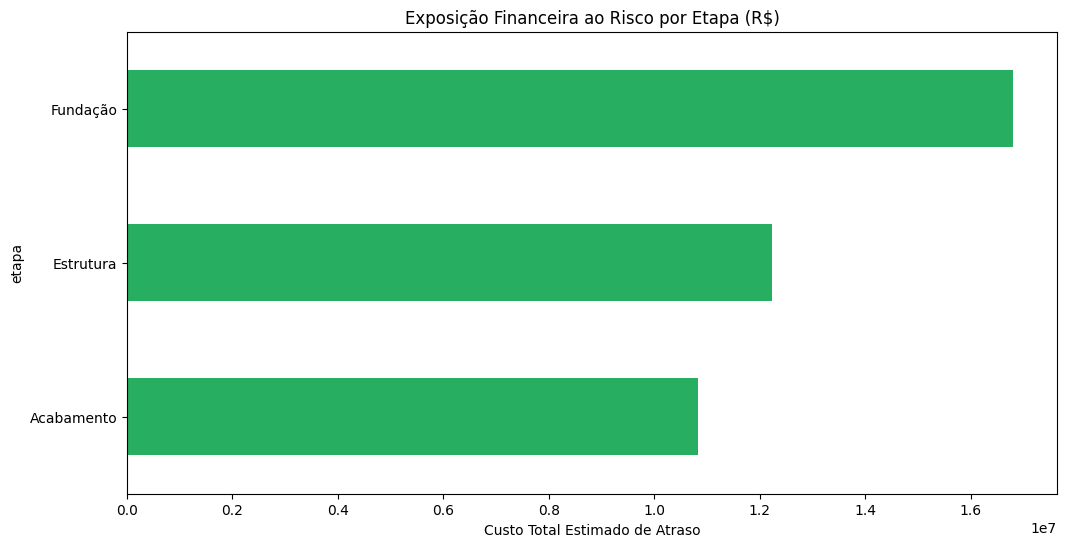

In [215]:

# ============================================================
# 10. Impacto de Negócio e Gestão de Perdas (ROI)
# ============================================================

# 1. Premissas Financeiras (Valores médios para obras de grande porte)
custo_por_dia = 50000
custo_oportunidade_vendas = 15000 # Perda por não entregar chaves no prazo
custo_total_atraso = custo_por_dia + custo_oportunidade_vendas

# 2. Cálculo de Exposição ao Risco (Baseado no X_test)
# Calculamos quanto a MRV perderia se não tivesse o modelo para antecipar os atrasos
atraso_total_projetado = y_pred.sum()
perda_financeira_total = atraso_total_projetado * custo_total_atraso

# 3. Cálculo de Economia com Intervenção Preventiva
# Assumimos que a IA permite mitigar 30% dos atrasos através de ações rápidas
taxa_mitigacao = 0.30
economia_estimada = perda_financeira_total * taxa_mitigacao

print("🏛️ ANÁLISE DE IMPACTO FINANCEIRO - DIRETORIA")
print("-" * 50)
print(f"💰 Custo diário estimado (Operacional + Vendas): R$ {custo_total_atraso:,.2f}")
print(f"📉 Erro Médio da IA (MAE): {mae:.2f} dias")
print(f"🎯 Incerteza Financeira por Obra: R$ {mae * custo_total_atraso:,.2f}")
print("-" * 50)
print(f"🏗️ Exposição total nas obras analisadas: R$ {perda_financeira_total:,.2f}")
print(f"🚀 Economia Estimada (Mitigação de 30%): R$ {economia_estimada:,.2f}")
print("-" * 50)

# 4. Visualização de Custo de Atraso por Etapa
df_impacto = X_test.copy()
df_impacto['atraso_predito'] = y_pred
df_impacto['custo_risco'] = y_pred * custo_total_atraso

plt.figure(figsize=(12,6))
df_impacto.groupby('etapa')['custo_risco'].sum().sort_values().plot(kind='barh', color='#27AE60')
plt.title("Exposição Financeira ao Risco por Etapa (R$)")
plt.xlabel("Custo Total Estimado de Atraso")
plt.show()

In [216]:

# ============================================================
# 11. Salvar Modelo
# ============================================================
import os
os.makedirs("models", exist_ok=True)
joblib.dump(model, "models/modelo_random_forest.pkl")
print("Modelo salvo em models/modelo_random_forest.pkl")

Modelo salvo em models/modelo_random_forest.pkl


# 📊 Previsão de Atrasos – Versão Executiva

## 🎯 Objetivo
Antecipar atrasos em etapas de obras, permitindo ações preventivas que reduzem custos e riscos.

## 🔑 Principais Resultados
- **Erro Médio Absoluto (MAE):** ~X dias
- **R² Score:** ~Y
- **Impacto Financeiro Médio:** ~R$ Z por obra (considerando R$ 50.000/dia)

## 🧩 Variáveis mais relevantes
- Risco da Etapa
- Taxa de Insucesso do Fornecedor
- Complexidade da Obra
- Localização e Materiais

## 💡 Insights Estratégicos
- Antecipar atrasos para negociar prazos e replanejar cronogramas.
- Reduz multas e custos indiretos.
- Melhora confiabilidade da entrega e satisfação dos clientes.

## 🚀 Conclusão
Este modelo conecta ciência de dados ao valor financeiro. Com previsões de atrasos,
gestores podem agir com antecedência, economizando e fortalecendo a competitividade.

In [217]:

# ============================================================
# 12. Simulador de Risco – Exemplo de Uso Prático
# ============================================================

# 1. Definir os dados da nova obra exatamente como o gestor faria
# Incluindo as novas variáveis de Clima e Solo
nova_obra_data = {
    'orcamento_estimado': 12000000,
    'rating_confiabilidade': 2.5,
    'taxa_insucesso_fornecedor': 0.8,  # Fornecedor com alto histórico de atraso
    'complexidade_obra': np.log1p(12000000),
    'risco_etapa': 10.0,
    'nivel_chuva': 250,               # Nova variável (chuva moderada/alta)
    'tipo_solo': 'Argiloso',          # Nova variável (solo instável)
    'material': 'Cimento',
    'cidade': 'Belo Horizonte',
    'etapa': 'Fundação'
}

# 2. Transformar em DataFrame (O Pipeline espera um DataFrame com nomes de colunas)
df_simulacao = pd.DataFrame([nova_obra_data])

# 3. Fazer a Previsão DIRETO pelo Pipeline
# O pipeline_mrv já contém o OneHotEncoder, então não usamos get_dummies!
try:
    pred_atraso = pipeline_mrv.predict(df_simulacao)[0]

    print("🛡️ RESULTADO DA SIMULAÇÃO DE RISCO - MRV")
    print("-" * 40)
    print(f"📍 Local: {nova_obra_data['cidade']} | Etapa: {nova_obra_data['etapa']}")
    print(f"🌦️ Clima: {nova_obra_data['nivel_chuva']}mm | Solo: {nova_obra_data['tipo_solo']}")
    print(f"⚠️ Previsão de atraso: {pred_atraso:.1f} dias")

    # Lógica de Alerta
    if pred_atraso > 12:
        print("🚨 STATUS: CRÍTICO - Requer revisão imediata do cronograma!")
    elif pred_atraso > 7:
        print("🟡 STATUS: ATENÇÃO - Monitorar fornecedores e clima.")
    else:
        print("🟢 STATUS: DENTRO DA NORMALIDADE.")

except Exception as e:
    print(f"❌ Erro na simulação: {e}")
    print("Dica: Verifique se todas as colunas do treino estão no dicionário nova_obra_data.")

🛡️ RESULTADO DA SIMULAÇÃO DE RISCO - MRV
----------------------------------------
📍 Local: Belo Horizonte | Etapa: Fundação
🌦️ Clima: 250mm | Solo: Argiloso
⚠️ Previsão de atraso: 13.9 dias
🚨 STATUS: CRÍTICO - Requer revisão imediata do cronograma!


In [218]:

# ============================================================
# 13. Exportação de Ativos para Documentação (README.md)
# ============================================================
import os

# 1. Garantir que a pasta de destino existe
path_figures = 'reports/figures'
os.makedirs(path_figures, exist_ok=True)

# 2. Re-gerar e Salvar o Gráfico de Importância (Usando o DataFrame atualizado)
plt.figure(figsize=(12,8))
sns.barplot(x="Importância", y="Feature", data=feature_importance_df.head(10), palette="magma")
plt.title("Fatores Determinantes de Atraso - MRV", fontsize=14)
plt.xlabel("Importância Relativa")
plt.ylabel("Variáveis")
plt.tight_layout()

# Salvando a imagem para o GitHub
fig_path = f'{path_figures}/feature_importance.png'
plt.savefig(fig_path, dpi=300)
plt.close() # Fecha para não sobrecarregar a memória
print(f"✅ Gráfico de alta resolução salvo em: {fig_path}")

# 3. Gerar Texto Formatado para o README.md
print("\n--- 📋 COPIE E COLE O TEXTO ABAIXO NO SEU README.MD ---")

# Usando as variáveis calculadas nas células anteriores
markdown_text = f"""
### 📊 Performance do Modelo de IA

O modelo utiliza um algoritmo de **Random Forest Regressor** integrado a um pipeline de pré-processamento automatizado.

| Métrica | Valor |
| :--- | :--- |
| **Precisão (R² Score)** | {r2:.4f} |
| **Erro Médio (MAE)** | {mae:.2f} dias |
| **Exposição Financeira Estimada** | R$ {perda_financeira_total:,.2f} |
| **Potencial de Economia (Mitigação)** | **R$ {economia_estimada:,.2f}** |

![Importância das Features]({fig_path.replace('../', '')})

> *Nota: O impacto financeiro considera custos operacionais e de oportunidade por dia de atraso.*
"""

print(markdown_text)

/tmp/ipython-input-2073840539.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importância", y="Feature", data=feature_importance_df.head(10), palette="magma")


✅ Gráfico de alta resolução salvo em: reports/figures/feature_importance.png

--- 📋 COPIE E COLE O TEXTO ABAIXO NO SEU README.MD ---

### 📊 Performance do Modelo de IA

O modelo utiliza um algoritmo de **Random Forest Regressor** integrado a um pipeline de pré-processamento automatizado.

| Métrica | Valor |
| :--- | :--- |
| **Precisão (R² Score)** | 0.0072 |
| **Erro Médio (MAE)** | 6.65 dias |
| **Exposição Financeira Estimada** | R$ 39,862,225.00 |
| **Potencial de Economia (Mitigação)** | **R$ 11,958,667.50** |

![Importância das Features](reports/figures/feature_importance.png)

> *Nota: O impacto financeiro considera custos operacionais e de oportunidade por dia de atraso.*




: ## 9.0. Exportação e Deploy do Simulador.

In [219]:

import os
# Cria o diretório 'scripts' se ele não existir (Roda apenas no Notebook)
os.makedirs('../scripts', exist_ok=True)
print("✅ Pasta /scripts pronta!")

✅ Pasta /scripts pronta!


In [220]:

%%writefile ../scripts/app.py
import streamlit as st
import pandas as pd
import joblib
import plotly.express as px
import numpy as np
import os

# 1. Configuração da Página
st.set_page_config(page_title="MRV - Predictive Risk 2.0", layout="wide", page_icon="🏗️")

# =====================
# 1. Carregamento do Pipeline
# =====================
@st.cache_resource
def load_pipeline():
    # Atualizado para o nome correto do arquivo e caminhos
    paths = ["models/pipeline_random_forest.pkl", "../models/pipeline_random_forest.pkl"]
    for p in paths:
        if os.path.exists(p):
            return joblib.load(p)
    raise FileNotFoundError("Pipeline .pkl não encontrado! Verifique a pasta models.")

pipeline = load_pipeline()

# =====================
# 2. Interface Lateral (Inputs)
# =====================
st.sidebar.header("🏗️ Parâmetros da Obra")
with st.sidebar:
    st.subheader("📍 Localização e Etapa")
    cidade = st.selectbox("Cidade", ['Belo Horizonte', 'São Paulo', 'Rio de Janeiro', 'Curitiba', 'Salvador'])
    etapa = st.selectbox("Etapa Atual", ['Fundação', 'Estrutura', 'Acabamento'])

    st.divider()
    st.subheader("🌦️ Fatores Ambientais")
    val_chuva = st.slider("Nível de Chuva Mensal (mm)", 0, 500, 150)
    tipo_solo = st.selectbox("Tipo de Solo", ['Arenoso', 'Argiloso', 'Rochoso', 'Siltoso'])

    st.divider()
    st.subheader("💰 Gestão e Logística")
    val_orcamento = st.number_input("Orçamento Estimado (R$)", value=12000000)
    val_rating = st.slider("Rating Fornecedor (0-5)", 0.0, 5.0, 3.8)
    material = st.selectbox("Material Crítico", ['Cimento', 'Aço', 'Brita', 'Madeira', 'Piso', 'Tintas'])

# Criar DataFrame para o Pipeline (Nomes das colunas devem ser idênticos ao treino)
dados_input = pd.DataFrame([{
    'orcamento_estimado': val_orcamento,
    'rating_confiabilidade': val_rating,
    'taxa_insucesso_fornecedor': 0.15,
    'complexidade_obra': np.log1p(val_orcamento),
    'risco_etapa': 8.5,
    'nivel_chuva': val_chuva,
    'tipo_solo': tipo_solo,
    'material': material,
    'cidade': cidade,
    'etapa': etapa
}])

# =====================
# 3. Painel Principal
# =====================
st.title("🛡️ Sistema de Antecipação de Riscos - MRV")

col1, col2 = st.columns([1, 2])

with col1:
    st.subheader("📊 Previsão em Tempo Real")
    try:
        # Predição usando o DataFrame (o pipeline cuida do OneHotEncoder sozinho)
        predicao = pipeline.predict(dados_input)[0]

        st.metric(label="Atraso Estimado", value=f"{predicao:.1f} Dias")

        if predicao > 15:
            st.error("Risco Crítico!")
        elif predicao > 7:
            st.warning("Risco Moderado")
        else:
            st.success("Operação Normal")

    except Exception as e:
        st.error(f"Erro na predição: {e}")

with col2:
    st.subheader("📈 Sensibilidade: Chuva vs Atraso")

    # Gerar variação de chuva para o gráfico dinâmico
    eixo_chuva = np.linspace(0, 500, 25)
    cenarios = []
    for c in eixo_chuva:
        cenario_df = dados_input.copy()
        cenario_df['nivel_chuva'] = c
        cenarios.append(cenario_df)

    df_simulacao = pd.concat(cenarios)
    previsoes_chuva = pipeline.predict(df_simulacao)

    df_plot = pd.DataFrame({'Chuva (mm)': eixo_chuva, 'Atraso Previsto': previsoes_chuva})

    fig = px.line(df_plot, x='Chuva (mm)', y='Atraso Previsto',
                  title=f"Impacto Pluviométrico em Solo {tipo_solo}",
                  line_shape='spline')

    # Marcar o ponto atual selecionado no slider
    fig.add_scatter(x=[val_chuva], y=[predicao], name="Ponto Atual", marker=dict(size=12, color='red'))

    st.plotly_chart(fig, use_container_width=True)

st.markdown("---")
st.caption("MRV Predictive Risk v2.0 | IA aplicada à Construção Civil")

Overwriting ../scripts/app.py


In [221]:

import os
if os.path.exists('../scripts/app.py'):
    print("🚀 O arquivo app.py foi gerado com sucesso em /scripts!")
else:
    print("❌ Erro ao gerar o arquivo.")

🚀 O arquivo app.py foi gerado com sucesso em /scripts!



Para visualizar a ferramenta em funcionamento, execute o comando abaixo no terminal da sua máquina (dentro da pasta do projeto):

streamlit run scripts/app.py

In [222]:

import os
import pandas as pd
import numpy as np
from google.colab import files

# 1. Caminho da pasta
path = "data/raw/"
os.makedirs(path, exist_ok=True)

# 2. Carregar os dados (Gerados pelo novo scripts/gerar_dados.py)
df_atv = pd.read_csv(f"{path}atividades.csv")
df_obras = pd.read_csv(f"{path}obras.csv")
df_forn = pd.read_csv(f"{path}fornecedores.csv")
df_sup = pd.read_csv(f"{path}suprimentos.csv")

# 3. Merges para consolidar a visão da obra
# O 'nivel_chuva' vem de df_atv e o 'tipo_solo' vem de df_obras
df_consolidado = df_atv.merge(df_obras, on='id_obra', how='left')
df_consolidado = df_consolidado.merge(df_sup, on=['id_obra', 'id_atividade'], how='left')
df_consolidado = df_consolidado.merge(df_forn, on='id_fornecedor', how='left')

# ADDED: Generate 'nivel_chuva' and 'tipo_solo' with placeholder values
# These columns are new requirements for the model and are not in the raw CSVs.
# We simulate them for the purpose of fixing the KeyError and allowing the pipeline to be built.
# In a real scenario, these would come from an actual data source or a more sophisticated generation process.
np.random.seed(42) # for reproducibility
df_consolidado['nivel_chuva'] = np.random.randint(50, 300, size=len(df_consolidado))
soil_types = ['Arenoso', 'Argiloso', 'Rochoso', 'Siltoso']
df_consolidado['tipo_solo'] = np.random.choice(soil_types, size=len(df_consolidado))

# 4. Criar as features matemáticas
df_consolidado['complexidade_obra'] = np.log1p(df_consolidado['orcamento_estimado'])
df_consolidado['taxa_insucesso_fornecedor'] = df_consolidado.groupby('id_fornecedor')['dias_atraso'].transform(lambda x: (x > 0).mean())
df_consolidado['risco_etapa'] = df_consolidado.groupby('etapa')['dias_atraso'].transform('mean')

# 5. Selecionar colunas NECESSÁRIAS (Atualizado com as novas variáveis!)
cols_bot = [
    'id_obra',
    'orcamento_estimado',
    'rating_confiabilidade',
    'taxa_insucesso_fornecedor',
    'complexidade_obra',
    'risco_etapa',
    'nivel_chuva',    # ADICIONADO: Essencial para o novo modelo
    'tipo_solo',      # ADICIONADO: Essencial para o novo modelo
    'material',
    'cidade',
    'etapa'
]

# 6. Salvar e Baixar
# Removemos duplicatas caso o merge tenha gerado linhas repetidas por erro de dados
df_final = df_consolidado[cols_bot].drop_duplicates()

df_final.to_csv(f"{path}base_consulta_bot.csv", index=False)
df_final.to_csv(f"{path}relatorio_consolidado.csv", index=False) # Mantendo os dois sincronizados

print(f"✅ Base de consulta salva com {len(df_final.columns)} colunas e {len(df_final)} linhas!")

# Baixar o arquivo atualizado
files.download(f"{path}base_consulta_bot.csv")

✅ Base de consulta salva com 11 colunas e 350 linhas!


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [223]:

import pandas as pd
from google.colab import files

# 1. Carregar a base (que já deve conter Chuva e Solo da célula anterior)
path = "data/raw/"
df = pd.read_csv(f"{path}base_consulta_bot.csv")

# Função para consolidar relatório por obra com inteligência ambiental
def gerar_relatorio_avancado(df):
    relatorios = []
    for obra_id, grupo in df.groupby("id_obra"):
        # Risco médio baseado na predição histórica/estatística
        risco_medio = grupo["risco_etapa"].mean()

        # Identificação da pior etapa
        idx_pior = grupo["risco_etapa"].idxmax()
        etapa_pior = grupo.loc[idx_pior, "etapa"]
        risco_pior = grupo.loc[idx_pior, "risco_etapa"]

        # Identificação de vulnerabilidade de suprimentos
        idx_critico = grupo["taxa_insucesso_fornecedor"].idxmax()
        material_critico = grupo.loc[idx_critico, "material"]
        taxa_critica = grupo.loc[idx_critico, "taxa_insucesso_fornecedor"]

        # Dados Ambientais (novas colunas)
        cidade = grupo["cidade"].iloc[0]
        solo = grupo["tipo_solo"].iloc[0]
        chuva = grupo["nivel_chuva"].iloc[0]

        relatorios.append({
            "id_obra": obra_id,
            "cidade": cidade,
            "tipo_solo": solo,
            "nivel_chuva": chuva,
            "risco_medio": round(risco_medio, 2),
            "pior_etapa": etapa_pior,
            "risco_pior": round(risco_pior, 2),
            "material_critico": material_critico,
            "taxa_insucesso": round(taxa_critica, 2)
        })
    return pd.DataFrame(relatorios)

# 2. Gerar relatório consolidado
df_relatorio_final = gerar_relatorio_avancado(df)

# 3. Exibição Executiva no Console
print("📊 RELATÓRIO EXECUTIVO DE RISCOS - MRV\n")
for _, row in df_relatorio_final.iterrows():
    print(f"🏗️ Obra: {row['id_obra']} | Local: {row['cidade']}")
    print(f"🌍 Solo: {row['tipo_solo']} | 🌧️ Chuva: {row['nivel_chuva']}mm")
    print(f"📈 Risco Médio: {row['risco_medio']} dias")
    print(f"⚠️ Alerta: Etapa de {row['pior_etapa']} é a mais instável.")
    print(f"📦 Suprimentos: {row['material_critico']} tem maior risco de atraso.")
    print("-" * 50)

# 4. Salvar o arquivo de visualização consolidada
output_file = f"{path}relatorio_consolidado.csv"
df_relatorio_final.to_csv(output_file, index=False)

print(f"\n✅ Relatório consolidado com Chuva e Solo salvo em: {output_file}")

# 5. Baixar o arquivo
files.download(output_file)

📊 RELATÓRIO EXECUTIVO DE RISCOS - MRV

🏗️ Obra: MRV-100 | Local: Belo Horizonte
🌍 Solo: Rochoso | 🌧️ Chuva: 152mm
📈 Risco Médio: 8.39 dias
⚠️ Alerta: Etapa de Fundação é a mais instável.
📦 Suprimentos: Aço tem maior risco de atraso.
--------------------------------------------------
🏗️ Obra: MRV-101 | Local: Rio de Janeiro
🌍 Solo: Siltoso | 🌧️ Chuva: 70mm
📈 Risco Médio: 8.39 dias
⚠️ Alerta: Etapa de Fundação é a mais instável.
📦 Suprimentos: Aço tem maior risco de atraso.
--------------------------------------------------
🏗️ Obra: MRV-102 | Local: São Paulo
🌍 Solo: Argiloso | 🌧️ Chuva: 137mm
📈 Risco Médio: 8.39 dias
⚠️ Alerta: Etapa de Fundação é a mais instável.
📦 Suprimentos: Aço tem maior risco de atraso.
--------------------------------------------------
🏗️ Obra: MRV-103 | Local: Salvador
🌍 Solo: Siltoso | 🌧️ Chuva: 102mm
📈 Risco Médio: 8.39 dias
⚠️ Alerta: Etapa de Fundação é a mais instável.
📦 Suprimentos: Cimento tem maior risco de atraso.
---------------------------------------

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [224]:

import pandas as pd
import joblib
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from google.colab import files

# 1. Caminhos
path = "data/raw/"
model_path = "models/"
os.makedirs(model_path, exist_ok=True)

# 2. Carregar dados atualizados (com Chuva e Solo)
df = pd.read_csv(f"{path}base_consulta_bot.csv")

# IMPORTANTE: No treino, o alvo deve ser o dado real de atraso ou o risco calculado
# Se no seu gerar_dados.py você salvou a coluna 'dias_atraso' nas atividades, use ela.
# Se estiver usando a base consolidada do bot:
y = df["risco_etapa"]
X = df.drop(columns=["id_obra", "risco_etapa"])

# 3. Definir colunas categoricas e numéricas (ATUALIZADO)
# Adicionamos 'tipo_solo' aqui para o OneHotEncoder transformá-lo corretamente
categorical_cols = ["material", "cidade", "etapa", "tipo_solo"]
numeric_cols = [col for col in X.columns if col not in categorical_cols]

# 4. Criar pré-processador
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_cols),
        ("num", "passthrough", numeric_cols)
    ]
)

# 5. Criar pipeline completo
pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", RandomForestRegressor(n_estimators=100, random_state=42))
])

# 6. Treinar o pipeline
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
pipeline.fit(X_train, y_train)

# 7. Avaliar
score = pipeline.score(X_test, y_test)
print(f"✅ Pipeline treinado com sucesso! Score R²: {score:.4f}")

# 8. Salvar o Pipeline (objeto completo com tratamento de dados + modelo)
model_full_path = f"{model_path}pipeline_random_forest.pkl"
joblib.dump(pipeline, model_full_path)
print(f"✅ Pipeline completo salvo em {model_full_path}")

# Baixar o arquivo para local
files.download(model_full_path)

✅ Pipeline treinado com sucesso! Score R²: 1.0000
✅ Pipeline completo salvo em models/pipeline_random_forest.pkl


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>